简单图像识别
===
在神经网络出现之前，我们一般通过HOG、SIFT、SURF等方法从图像中提取一些特征，并通过特征确定物体类别。接下来我们利用图像颜色的直方图来执行简单的图像识别

# 1.图像减色与柱状图
- 将图像进行减色处理
- 创建减色图像的直方图。直方图中，RGB分别取四个值，但为了区分它们，$B=[1,4]、G=[5,8]、R=[9,12]$，这样$bin=12$。请注意，我们还需要为每个图像保存相应的柱状图。
- 将上一步中计算得到的柱状图记为database

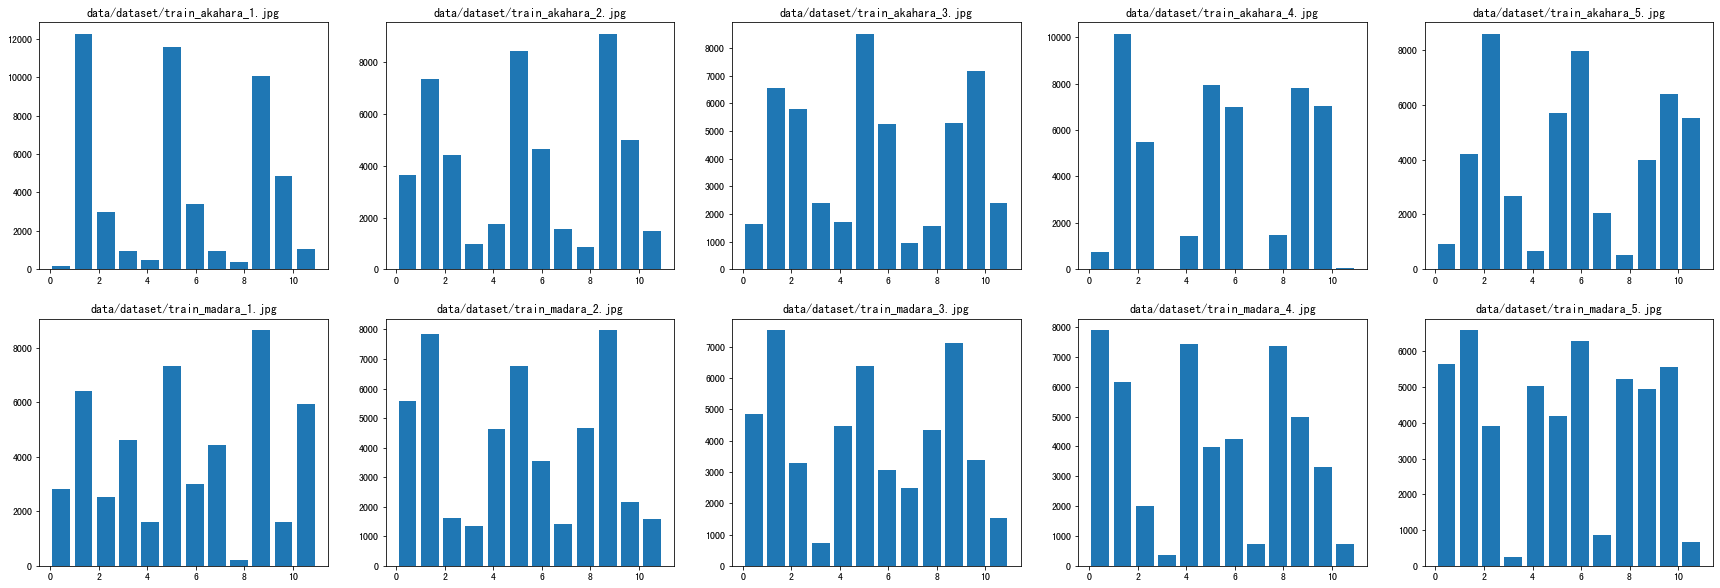

In [9]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import os

DATA_PATH = os.path.join("data", "dataset")

def dic_color(img):
    img //= 63
    img = img * 64 + 32
    return img

def get_DB():
    train = glob(os.path.join(DATA_PATH, "train_*"))
    train.sort()

    # prepare database
    db = np.zeros((len(train), 13), dtype=np.int32)
    pdb = []
    
    # each image
    for i, path in enumerate(train):
        # get histogram
        for j in range(4):
            db[i, j] = len(np.where(img[..., 0] == (64 * j + 32))[0])
            db[i, j+4] = len(np.where(img[..., 1] == (64 * j + 32))[0])
            db[i, j+8] = len(np.where(img[..., 2] == (64 * j + 32))[0])

        # get class
        if 'akahara' in path:
            cls = 0
        elif 'madara' in path:
            cls = 1

        # store class label
        db[i, -1] = cls
        pdb.append(path)
    return db, pdb

db, pdb = get_DB()
plt.figure(figsize=(30,10), facecolor='white')
for i, path in enumerate(pdb):
    img = dic_color(cv2.imread(path))
    img_h = img.copy() // 64
    img_h[..., 1] += 4
    img_h[..., 2] += 8
    plt.subplot(2, 5, i+1)
    plt.hist(img_h.ravel(), bins=12, rwidth=0.8)
    plt.title(path)

# 2.判别类型
请使用测试数据集，然后输出每张图片与各个图像直方图差别最小的(训练数据集的)文件名和预测类别。这种评价方法被称为最近邻法（Neareset Neighbour）

In [10]:
def test_DB(db, pdb):
    # get test image path
    test = glob(os.path.join(DATA_PATH, "test_*"))
    test.sort()

    success_num = 0.

    # each image
    for path in test:
        # read image
        img = dic_color(cv2.imread(path))

        # get histogram
        hist = np.zeros(12, dtype=np.int32)
        for j in range(4):
            hist[j] = len(np.where(img[..., 0] == (64 * j + 32))[0])
            hist[j+4] = len(np.where(img[..., 1] == (64 * j + 32))[0])
            hist[j+8] = len(np.where(img[..., 2] == (64 * j + 32))[0])

        # get histogram difference
        difs = np.abs(db[:, :12] - hist)
        difs = np.sum(difs, axis=1)

        # get argmin of difference
        pred_i = np.argmin(difs)

        # get prediction label
        pred = db[pred_i, -1]

        if pred == 0:
            pl = "akahara"
        elif pred == 1:
            pl = "madara"
        
        print(path, "is similar >>", pdb[pred_i], " Pred >>", pl)
test_DB(db, pdb)

data/dataset/test_akahara_1.jpg is similar >> data/dataset/train_akahara_1.jpg  Pred >> akahara
data/dataset/test_akahara_2.jpg is similar >> data/dataset/train_akahara_1.jpg  Pred >> akahara
data/dataset/test_madara_1.jpg is similar >> data/dataset/train_akahara_1.jpg  Pred >> akahara
data/dataset/test_madara_2.jpg is similar >> data/dataset/train_akahara_1.jpg  Pred >> akahara


# 3.评估

In [11]:
def test_DB(db, pdb):
    # get test image path
    test = glob(os.path.join(DATA_PATH, "test_*"))
    test.sort()

    accurate_N = 0.

    # each image
    for path in test:
        # read image
        img = dic_color(cv2.imread(path))

        # get histogram
        hist = np.zeros(12, dtype=np.int32)
        for j in range(4):
            hist[j] = len(np.where(img[..., 0] == (64 * j + 32))[0])
            hist[j+4] = len(np.where(img[..., 1] == (64 * j + 32))[0])
            hist[j+8] = len(np.where(img[..., 2] == (64 * j + 32))[0])

        # get histogram difference
        difs = np.abs(db[:, :12] - hist)
        difs = np.sum(difs, axis=1)

        # get argmin of difference
        pred_i = np.argmin(difs)

        # get prediction label
        pred = db[pred_i, -1]

        if pred == 0:
            pred_label = "akahara"
        elif pred == 1:
            pred_label = "madara"

        gt = "akahara" if "akahara" in path else "madara"

        if gt == pred_label:
            accurate_N += 1
        
        print(path, "is similar >>", pdb[pred_i], " Pred >>", pred_label)

    accuracy = accurate_N / len(test)
    print("Accuracy >>", accuracy, "({}/{})".format(int(accurate_N), len(test)))
test_DB(db, pdb)

data/dataset/test_akahara_1.jpg is similar >> data/dataset/train_akahara_1.jpg  Pred >> akahara
data/dataset/test_akahara_2.jpg is similar >> data/dataset/train_akahara_1.jpg  Pred >> akahara
data/dataset/test_madara_1.jpg is similar >> data/dataset/train_akahara_1.jpg  Pred >> akahara
data/dataset/test_madara_2.jpg is similar >> data/dataset/train_akahara_1.jpg  Pred >> akahara
Accuracy >> 0.5 (2/4)


# 4.使用KNN=3来进行分类

In [12]:
def test_DB(db, pdb, N=3):
    # get test image path
    test = glob(os.path.join(DATA_PATH, "test_*"))
    test.sort()

    accuracy_N = 0.

    # each image
    for path in test:
        # read image
        img = dic_color(cv2.imread(path))

        # get histogram
        hist = np.zeros(12, dtype=np.int32)
        for j in range(4):
            hist[j] = len(np.where(img[..., 0] == (64 * j + 32))[0])
            hist[j+4] = len(np.where(img[..., 1] == (64 * j + 32))[0])
            hist[j+8] = len(np.where(img[..., 2] == (64 * j + 32))[0])

        # get histogram difference
        difs = np.abs(db[:, :12] - hist)
        difs = np.sum(difs, axis=1)

        # get top N
        pred_i = np.argsort(difs)[:N]

        # predict class index
        pred = db[pred_i, -1]

        # get class label
        if len(pred[pred == 0]) > len(pred[pred == 1]):
            pl = "akahara"
        else:
            pl = 'madara'

        print(path, "is similar >> ", end='')
        for i in pred_i:
            print(pdb[i], end=', ')
        print("|Pred >>", pl)

        # count accuracy
        gt = "akahara" if "akahara" in path else "madara"
        if gt == pl:
            accuracy_N += 1.

    accuracy = accuracy_N / len(test)
    print("Accuracy >>", accuracy, "({}/{})".format(int(accuracy_N), len(test)))

test_DB(db, pdb)

data/dataset/test_akahara_1.jpg is similar >> data/dataset/train_akahara_1.jpg, data/dataset/train_akahara_2.jpg, data/dataset/train_akahara_3.jpg, |Pred >> akahara
data/dataset/test_akahara_2.jpg is similar >> data/dataset/train_akahara_1.jpg, data/dataset/train_akahara_2.jpg, data/dataset/train_akahara_3.jpg, |Pred >> akahara
data/dataset/test_madara_1.jpg is similar >> data/dataset/train_akahara_1.jpg, data/dataset/train_akahara_2.jpg, data/dataset/train_akahara_3.jpg, |Pred >> akahara
data/dataset/test_madara_2.jpg is similar >> data/dataset/train_akahara_1.jpg, data/dataset/train_akahara_2.jpg, data/dataset/train_akahara_3.jpg, |Pred >> akahara
Accuracy >> 0.5 (2/4)
